Time series is different from a regular regression problem because it is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case. Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. Analysis of a time series is important because it is the preparatory step before you develop a forecast of the series. It involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

In this blog post we'll examine some common techniques used in time series analysis by applying them to a data set containing daily opening values for the United Health Group from 2016 up to present day. 

[UnitedHealth Group](https://en.wikipedia.org/wiki/UnitedHealth_Group) Incorporated is an American for-profit managed health care company based in Minnetonka, Minnesota. It offers health care products and insurance services. It is the largest healthcare company in the world by revenue, with 2019 revenue of $242.2 billion. The company is ranked 6th on the 2019 Fortune 500.

## Model Based Forecasting includes

#### Classical & Statistical Learning 	
* Autoregressive integrated moving average (ARIMA)
* Exponential smoothing methods (e.g. Holt-Winters)
* Theta

When the underlying mechanisms are not known or are too complicated, e.g., the stock market, or not fully known, e.g., retail sales, it is usually better to apply a simple statistical model. Popular classical methods that belong to this category include ARIMA (autoregressive integrated moving average), exponential smoothing methods, such as Holt-Winters, and the Theta method. 

#### Machine Learning

* Recurrent neural networks (RNN)
* Quantile regression forest (QRF)
* Gradient boosting trees (GBM)
* Support vector regression (SVR)
* Gaussian Process regression (GP)

Machine learning models are of a black-box type and are used when interpretability is not a requirement. Both, classical and ML methods are not that different from each other, but distinguished by whether the models are more simple and interpretable or more complex and flexible. In practice. classical statistical algorithms tend to be much quicker and easier-to-use.

## Framework

### Step 1: Visualize the Time Series
It is essential to analyze the trends prior to building any kind of time series model. The details we are interested in pertains to any kind of trend, seasonality or random behaviour in the series.  

### Step 2: Stationarize the Series
Once we know the patterns, trends, cycles and seasonality , we can check if the series is stationary or not. Dickey – Fuller is one of the popular test to check the same. If the series is non-stationary, we can use one of the commonly used techniques to make a time series stationary:

1.  Detrending : Here, we simply remove the trend component from the time series. For instance, the equation of my time series is:

x(t) = (mean + trend * t) + error

We’ll simply remove the part in the parentheses and build model for the rest.

2. Differencing : This is the commonly used technique to remove non-stationarity. Here we try to model the differences of the terms and not the actual term. For instance,

x(t) – x(t-1) = ARMA (p ,  q)

This differencing is called as the Integration part in AR(I)MA. Now, we have three parameters

p : AR (AutoRegressive = the model takes advantage of the connection between a predefined number of lagged observations and the current one.)

d : I (Integrated = differencing between raw observations (eg. subtracting observations at different time steps).)

q : MA (Moving Average = the model takes advantage of the relationship between the residual error and the observations.)


3. Seasonality : Seasonality can easily be incorporated in the ARIMA model directly. 
 

### Step 3: Find Optimal Parameters
The parameters p,d,q can be found using  ACF and PACF plots. An addition to this approach is can be, if both ACF and PACF decreases gradually, it indicates that we need to make the time series stationary and introduce a value to “d”.

### Step 4: Build ARIMA Model
With the parameters in hand, we build ARIMA model. The value found in the previous section might be an approximate estimate and we need to explore more (p,d,q) combinations. The one with the lowest BIC and AIC should be our choice. We can also try some models with a seasonal component. Just in case, we notice any seasonality in ACF/PACF plots. 

### Step 5: Make Predictions
Once we have the final ARIMA model, we are ready to make predictions on the future time points. We can also visualize the trends to cross validate if the model works fine.

### References for this post:

* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
* https://medium.com/analytics-vidhya/preprocessing-for-time-series-forecasting-3a331dbfb9c2
* http://www.gregreda.com/2020/02/16/feature-engineering-with-time-gaps/
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/
* https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html
* http://bashtage.github.io/arch/doc/index.html
* https://www.alphavantage.co/documentation/
* https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # advanced vizs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import suptitle
import matplotlib.style as style
from IPython.display import display, HTML
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import KPSS, ZivotAndrews, VarianceRatio
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA


import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
plt.style.use('bmh')
warnings.filterwarnings('ignore') 
pd.set_option('display.width',100, 'display.max_rows',20, 'display.max_columns',9,'max_colwidth',100)

C:\Users\piush\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Download Data

In [2]:
from datetime import datetime
import pandas_datareader.data as web
import configparser
settings = configparser.ConfigParser()
settings.read('../data/processed/config.ini')
api_key = settings.get('AlphaVantage', 'api_key')
start = datetime(2016, 1, 1)
end = datetime.now()
f = web.DataReader("UNH", "av-daily", start=start,  end=end, api_key= api_key)

In [3]:
f.head()

,open,high,low,close,volume
2016-01-04,116.91,116.91,114.525,116.46,4990855
2016-01-05,116.72,117.89,116.210,116.68,2816727
2016-01-06,115.78,116.65,114.500,115.49,2677303
2016-01-07,113.63,114.09,111.420,112.09,5276916
2016-01-08,112.35,113.00,109.760,110.16,4422365


## Select the Opening Price

In [4]:
df = f['open'].to_frame().reset_index()
df.columns =['index','open']
df['index'] = pd.to_datetime(df['index'])
df.set_index("index", inplace=True)


## Plot

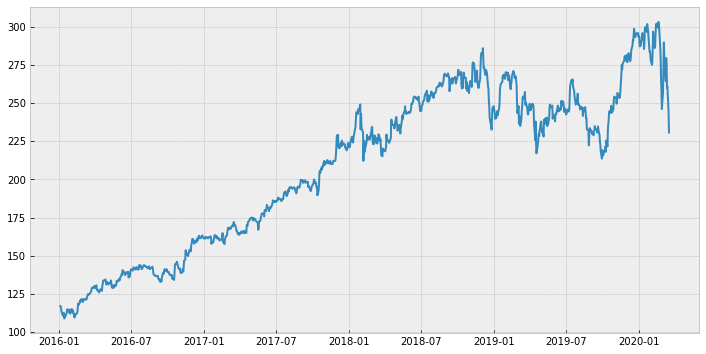

In [5]:
f, (ax1) = plt.subplots(1, figsize = (12, 6))
# preparation: input should be float type
plt.plot(df)
plt.show()

### Resample

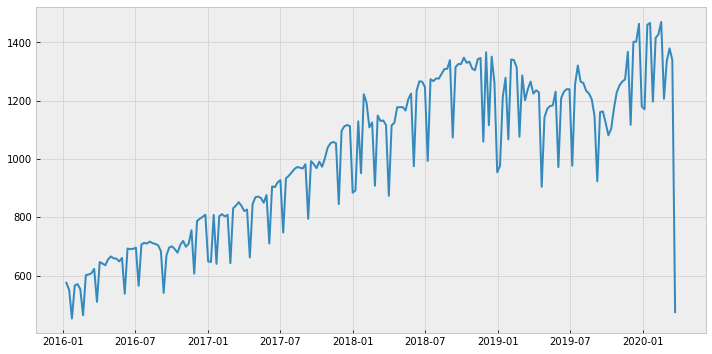

In [6]:
f, (ax1) = plt.subplots(1, figsize = (12, 6))
# Weekly Resample
df1 = df['open'].resample('W').sum().reset_index()
plt.plot(df1['index'],df1['open'])
plt.show()

### Patterns in a time series
Any time series may be split into the following components: 

Base Level + Trend + Seasonality + Error

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true. If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors. Furthermore, care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.

#### How to diffentiate between a ‘cyclic’ vs ‘seasonal’?

(Additive and multiplicative time series)

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error


In [7]:
def pattern_series(timeseries, model, freq):
    f, (ax1) = plt.subplots(1, figsize = (12, 9))
    decomposition = seasonal_decompose(timeseries, model=model, freq = freq)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.suptitle(model)
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

### Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

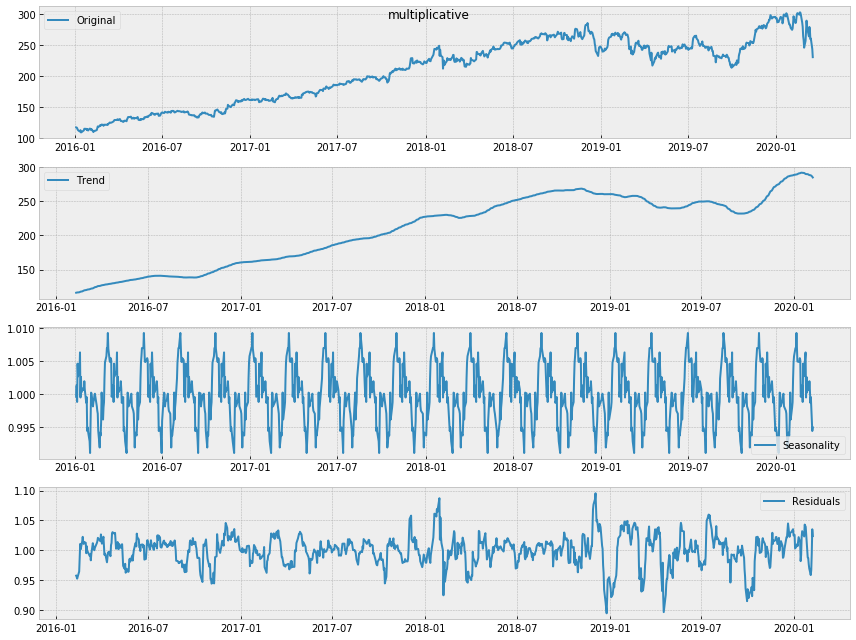

In [8]:
### Multiplicative
pattern_series(df['open'], 'multiplicative', 52)

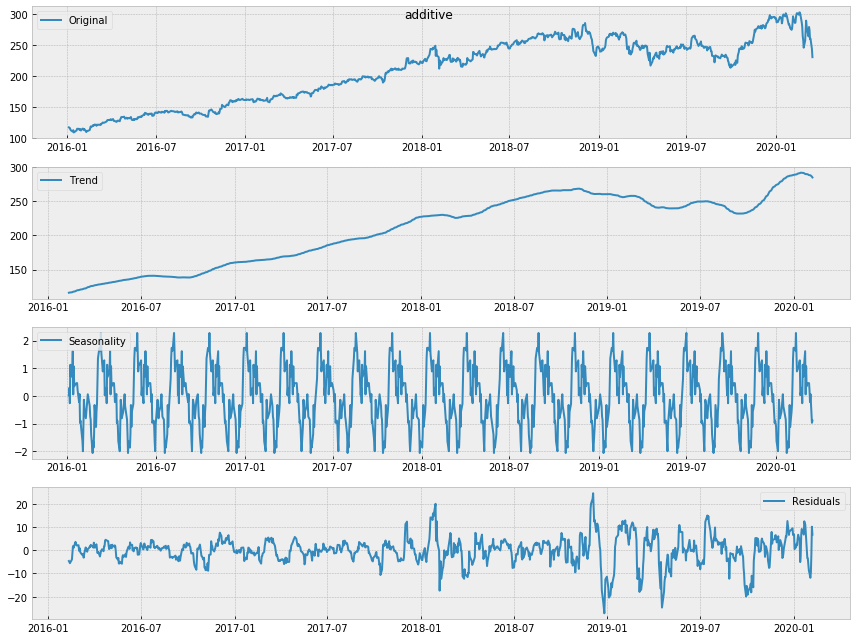

In [9]:
### Additive
pattern_series(df['open'],'additive', 52)

Here we can see that the trend, seasonality are separated out from data. If we look at the residuals of the multiplicative decomposition closely, it has no pattern left over. However, the addtive decomposition looks quite random which is good. Additive decomposition should be preferred for this particular series.

Note: Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

The numerical output of the trend, seasonal and residual components are stored in the decomposition output itself. We can extract them and put it in a dataframe.

In [10]:
# Extract the Components ----
# Actual Values = Sum of (Seasonal + Trend + Resid)
decomposition = seasonal_decompose(df['open'], model='additive', freq = 52)
df_reconstructed = pd.concat([decomposition.seasonal, decomposition.trend, decomposition.resid, decomposition.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
index,,,,
2016-01-04,0.024738,NaN,NaN,116.91
2016-01-05,0.291879,NaN,NaN,116.72
2016-01-06,-0.263111,NaN,NaN,115.78
2016-01-07,1.126474,NaN,NaN,113.63
2016-01-08,0.688270,NaN,NaN,112.35


## Lag Plots
A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one we see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

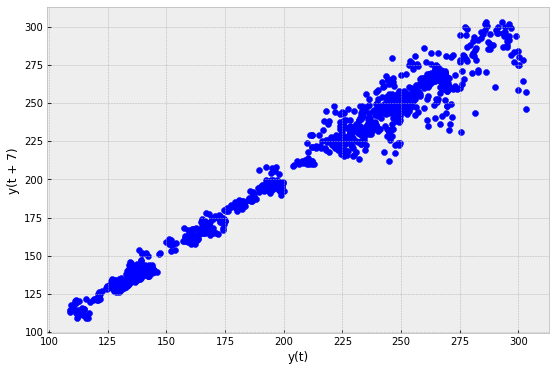

In [11]:
# Lag Plot
f, (ax1) = plt.subplots(1, figsize = (9, 6))
pd.plotting.lag_plot(df['open'], lag = 7)

## Stationarity

We cannot build a time series model unless our time series is stationary.  A stationary series is one where the values of the series is not a function of time. It's statistical properties such as mean, variance remain constant over time. Autocorrelation of the series is nothing but the correlation of the series with its previous values.

### Why make a non-stationary series stationary before forecasting?

An important reason is, autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors. 
We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent. Stationarizing the data is a unique aspect of ARIMA models - it helps to determine the parameters of the ARIMA model. If the residuals are stationary after being fed through a linear model, then the Gauss-Markov theorem guarantees us that we have found the best unbiased linear estimator (BLUE) of the data. Another way to think about this is that, if we see that the residuals are not stationary, then there is probably some pattern in the data that we should be able to incorporate into our model such that the residuals become stationary.

It's also important that the dataset is stationary, otherwise we run the risk of finding spurious correlations. A common example is the relationship between number of TVs per person and life expectancy. It's not likely that there's an actual causal relationship there. Rather, there could be a third variable that's driving both (wealth, say).

### What is the difference between white noise and a stationary series?

Like a stationary series, the white noise is also not a function of time, that is its mean and variance does not change over time. But the difference is, the white noise is completely random with a mean of 0. In white noise there is no pattern whatsoever. If we consider the sound signals in an FM radio as a time series, the blank sound you hear between the channels is white noise. Mathematically, a sequence of completely random numbers with mean zero is a white noise.

### How to check if a given series is stationary or not?

#### Visualizations
The most basic methods for stationarity detection rely on plotting the data, or functions of it, and determining visually whether they present some known property of stationary (or non-stationary) data. Looking at Autocorrelation Function (ACF) plots. Autocorrelation is the correlation of a signal with a delayed copy — or a lag — of itself as a function of the delay. When plotting the value of the ACF for increasing lags (a plot called a correlogram), the values tend to degrade to zero quickly for stationary time series, while for non-stationary data the degradation will happen more slowly

#### Looking at the data

Trying to determine whether a time series was generated by a stationary process just by looking at its plot is a dubious venture. However, there are some basic properties of non-stationary data that we can look for. 


#### Parametric tests
Another, more rigorous approach, to detecting stationarity in time series data is using statistical tests developed to detect specific types of stationarity, namely those brought about by simple parametric models of the generating stochastic process.

https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html
    
##### Unit root tests

###### The Dickey-Fuller Test
The Dickey-Fuller test was the first statistical test developed to test the null hypothesis that a unit root is present in an autoregressive model of a given time series and that the process is thus not stationary. The original test treats the case of a simple lag-1 AR model.

###### The KPSS Test
Another prominent test for the presence of a unit root is the KPSS test. [Kwiatkowski et al., 1992] Conversely to the Dickey-Fuller family of tests, the null hypothesis assumes stationarity around a mean or a linear trend, while the alternative is the presence of a unit root.
##### Variance ratio tests 
These are not usually used as unit root tests, and are instead used for testing whether a financial return series is a pure random walk versus having some predictability. The variance ratio compares the variance of a 1-period return to that of a multi-period return. The comparison length has to be set when initializing the test. This example compares 1-day to 7-day returns, and the null that the series is a pure random walk is rejected. Positive values indicate some negative autocorrelation (momentum).    

### How to make a series stationary?

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, average growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.


### How to treat missing values in a time series?

Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

* Backward Fill
* Linear Interpolation
* Quadratic interpolation
* Mean of nearest neighbors
* Mean of seasonal couterparts


In [12]:
def test_stationary(timeseries):
    f, (ax) = plt.subplots(1, figsize = (12, 6))
    #Determing rolling statistics
    rolmean = timeseries.rolling(15).mean()
    rolstd =  timeseries.rolling(15).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # KPSS test
    kpss = KPSS(timeseries)
    print(kpss.summary().as_text())
    
    # Changing the trend 
    print("KPSS change trend")
    kpss.trend = 'ct'
    print(kpss.summary().as_text())
    
    # The Zivot-Andrews test allows the possibility of a single structural break in the series.
    za = ZivotAndrews(timeseries)
    print(za.summary().as_text())
    
    # Variance Ratio Testing    
    vr = VarianceRatio(timeseries, 7)
    print(vr.summary().as_text())

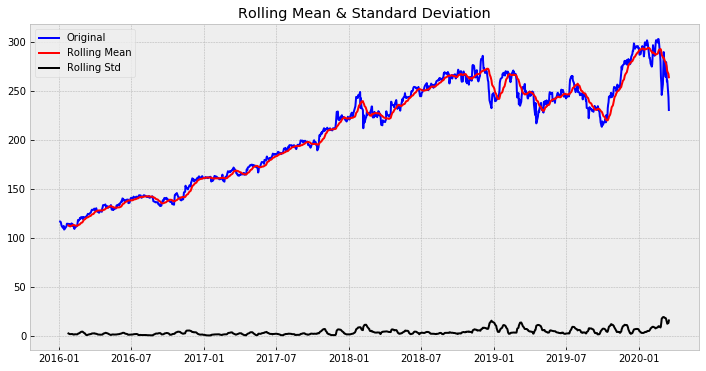

Results of Dickey-Fuller Test:
Test Statistic                   -1.792978
p-value                           0.383953
#Lags Used                       20.000000
Number of Observations Used    1037.000000
Critical Value (1%)              -3.436672
Critical Value (5%)              -2.864331
Critical Value (10%)             -2.568256
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  4.884
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  0.791
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0

In [13]:
test_stationary(df['open'])

### Estimating & Eliminating Trend

It is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

* Aggregation – taking average for a time period like monthly/weekly averages
* Smoothing – taking rolling averages
* Polynomial Fitting – fit a regression model

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. 


#### Log
So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

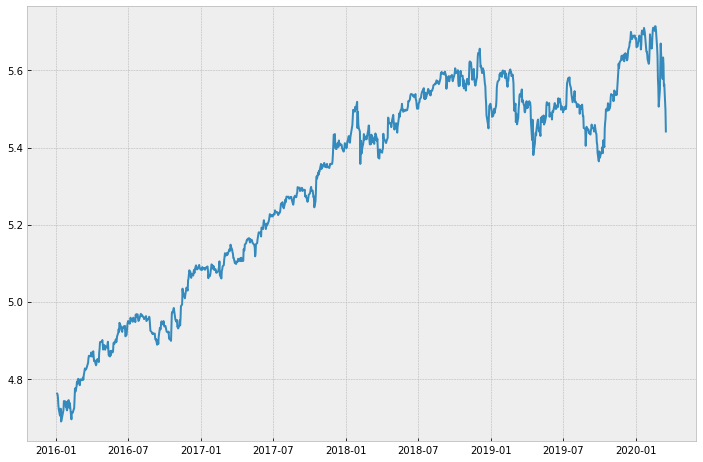

In [14]:
f, (ax1) = plt.subplots(1, figsize = (12, 8))
ts_log = np.log(df['open'])
plt.plot(ts_log)
plt.show()

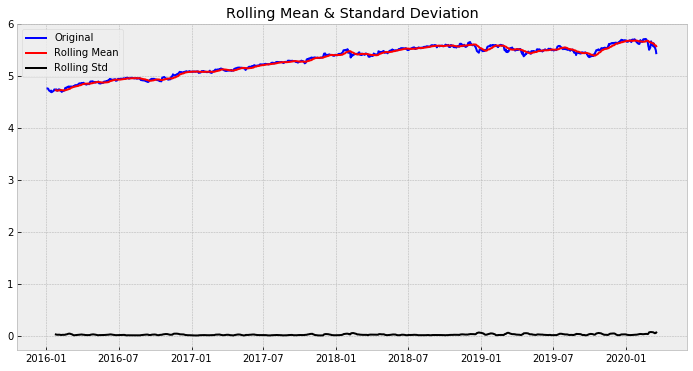

Results of Dickey-Fuller Test:
Test Statistic                   -2.217666
p-value                           0.199896
#Lags Used                       20.000000
Number of Observations Used    1037.000000
Critical Value (1%)              -3.436672
Critical Value (5%)              -2.864331
Critical Value (10%)             -2.568256
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  4.844
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  1.065
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0

In [15]:
test_stationary(ts_log)

We can see that the mean and std variations have large variations with time. Also, the Dickey-Fuller test statistic is not less than the 1% critical value, thus the TS is stationary with 99% confidence. 

### Moving average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 7 days, i.e. last 7 values. Pandas has specific functions defined for determining rolling statistics.

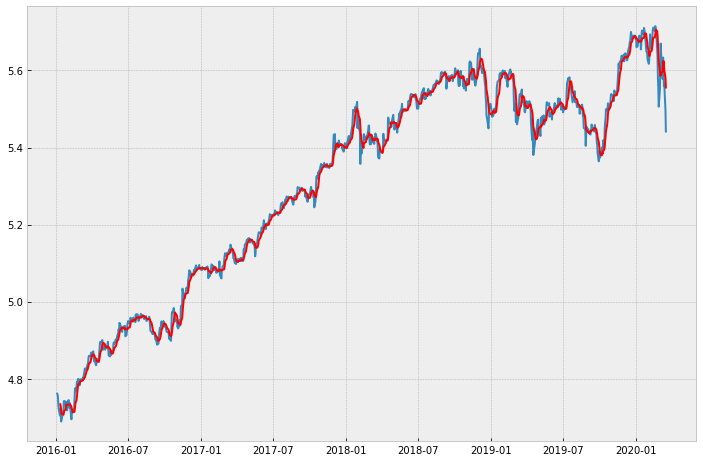

In [16]:
f, (ax1) = plt.subplots(1, figsize = (12, 8))
moving_avg = ts_log.rolling(7).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 7 values, rolling mean is not defined for first 6 values. This can be observed as:

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(8)

index
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12   -0.030009
2016-01-13   -0.005996
Name: open, dtype: float64

Notice the first 6 being Nan. Lets drop these NaN values and check the plots to test stationarity.

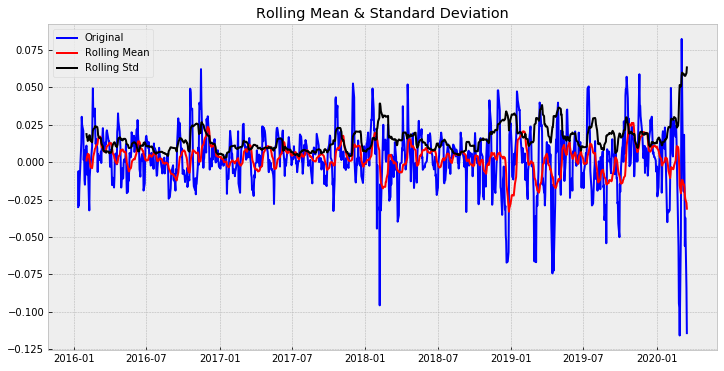

Results of Dickey-Fuller Test:
Test Statistic                -5.833252e+00
p-value                        3.930037e-07
#Lags Used                     1.600000e+01
Number of Observations Used    1.035000e+03
Critical Value (1%)           -3.436684e+00
Critical Value (5%)           -2.864337e+00
Critical Value (10%)          -2.568259e+00
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  0.316
P-value                         0.122
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  0.032
P-value                         0.838
Lags                               14
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 

In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationary(ts_log_moving_avg_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

### Exponentially-weighted moving average



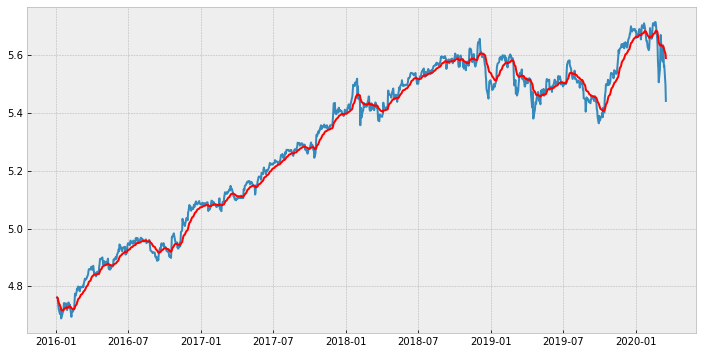

In [19]:
f, (ax1) = plt.subplots(1, figsize = (12, 6))
expwighted_avg = ts_log.ewm(halflife=7).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

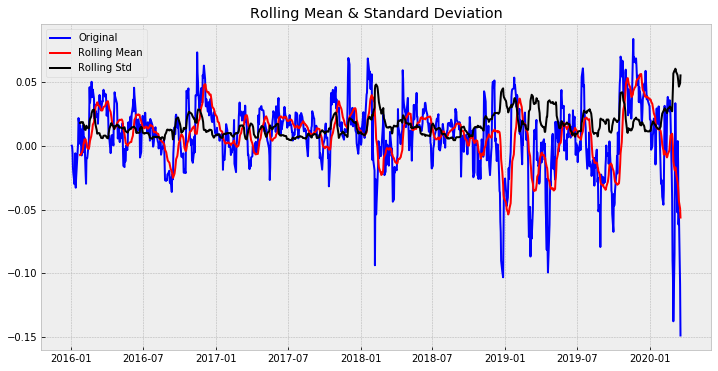

Results of Dickey-Fuller Test:
Test Statistic                   -4.206595
p-value                           0.000642
#Lags Used                       20.000000
Number of Observations Used    1037.000000
Critical Value (1%)              -3.436672
Critical Value (5%)              -2.864331
Critical Value (10%)             -2.568256
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  0.388
P-value                         0.078
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  0.056
P-value                         0.499
Lags                               18
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0

In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationary(ts_log_ewma_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

## Why and How to smoothen a time series?

Smoothening of a time series may be useful in:

Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
The smoothed version of series can be used as a feature to explain the original series itself.
Visualize the underlying trend better
So how to smoothen a series? Let’s discuss the following methods:

Take a moving average
Do a LOESS smoothing (Localized Regression)
Do a LOWESS smoothing (Locally Weighted Regression)
Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

https://www.machinelearningplus.com/time-series/time-series-analysis-python/

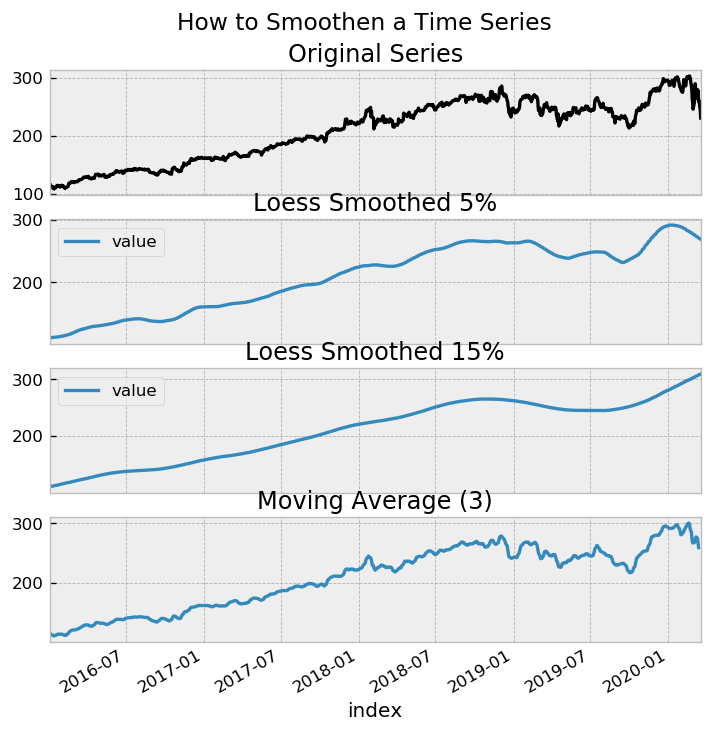

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Import
df_orig = df['open']

# 1. Moving Average
df_ma = df_orig.rolling(7, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig, np.arange(len(df_orig)), frac=0.05)[:, 1], index=df_orig.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df_orig, np.arange(len(df_orig)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_orig.plot(ax=axes[0], color='k', title='Original Series')
df_loess_5.plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15.plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1. Differencing – taking the differece with a particular time lag
2. Decomposition – modeling both trend and seasonality and removing them from the model.

#### Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

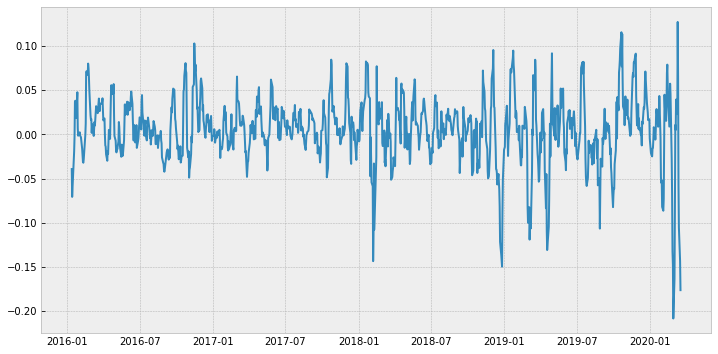

In [22]:
f, (ax1) = plt.subplots(1, figsize = (12, 6))
ts_log_diff = ts_log - ts_log.shift(7)
plt.plot(ts_log_diff)

In [23]:
ts_log_diff

index
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2020-03-11    0.065500
2020-03-12   -0.057361
2020-03-13   -0.105399
2020-03-16   -0.143647
2020-03-17   -0.176659
Name: open, Length: 1058, dtype: float64

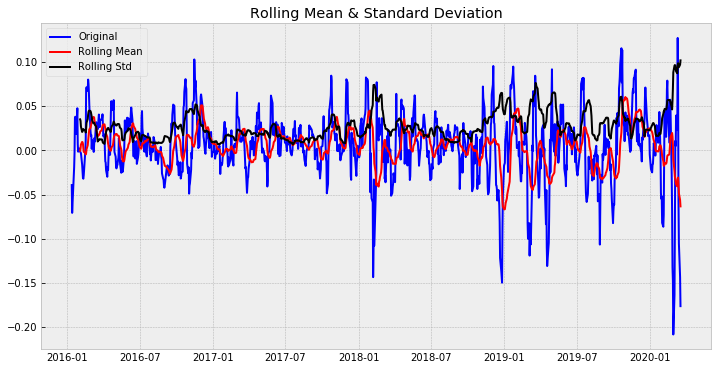

Results of Dickey-Fuller Test:
Test Statistic                   -5.181715
p-value                           0.000010
#Lags Used                       21.000000
Number of Observations Used    1029.000000
Critical Value (1%)              -3.436721
Critical Value (5%)              -2.864353
Critical Value (10%)             -2.568268
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  0.296
P-value                         0.139
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  0.034
P-value                         0.818
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0

In [24]:
ts_log_diff.dropna(inplace=True)
test_stationary(ts_log_diff)

#### This does not appear to have reduced trend considerably. 

The Dickey-Fuller test statistic is not significantly lower than the 1% critical value. So this TS is not very close to stationary. We can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

### Decomposition
We can model the residuals of the the logs. Lets check stationarity of residuals:

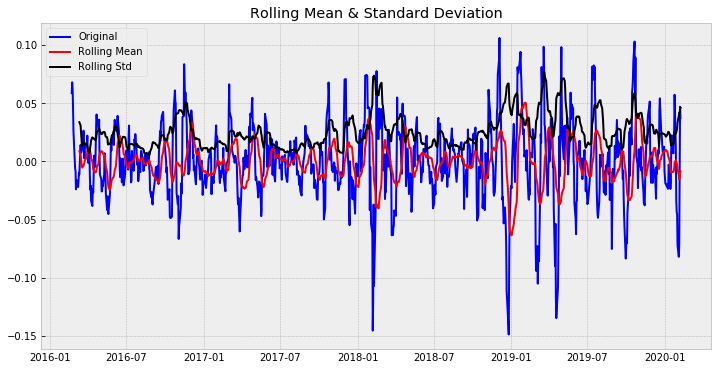

Results of Dickey-Fuller Test:
Test Statistic                -9.640191e+00
p-value                        1.528208e-16
#Lags Used                     2.200000e+01
Number of Observations Used    9.760000e+02
Critical Value (1%)           -3.437068e+00
Critical Value (5%)           -2.864506e+00
Critical Value (10%)          -2.568349e+00
dtype: float64
    KPSS Stationarity Test Results   
Test Statistic                  0.011
P-value                         0.997
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
KPSS change trend
    KPSS Stationarity Test Results   
Test Statistic                  0.008
P-value                         0.998
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 

In [25]:
decomposition = seasonal_decompose(ts_log_diff, model='additive', freq = 52)
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
test_stationary(ts_log_decompose)

### Let us see the performance of ts_log_diff on modelling.

### How to estimate the forecastability of a time series?
The more regular and repeatable patterns a time series has, the easier it is to forecast. The ‘Approximate Entropy’ can be used to quantify the regularity and unpredictability of fluctuations in a time series. The higher the approximate entropy, the more difficult it is to forecast it.

Another better alternate is the ‘Sample Entropy’.

Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. For example, a random time series with fewer data points can have a lower ‘approximate entropy’ than a more ‘regular’ time series, whereas, a longer random time series will have a higher ‘approximate entropy’. Sample Entropy handles this problem nicely. 

In [26]:
# https://en.wikipedia.org/wiki/Approximate_entropy
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ts_log_diff, m=2, r=0.2*np.std(ts_log_diff)))  

1.2404585496052403


In [27]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ts_log_diff, m=2, r=0.2*np.std(ts_log_diff)))  

1.2047427842086227


### Checking Stationarity (ACF and PACF Plots)

Another common method of checking to see if data is stationary is to plot its autocorrelation function. 

* Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
* Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The autocorrelation involves “sliding” or “shifting” a function and multiplying it with its unshifted self. This allows one to measure the overlap of the function with itself at different points in time. This process ends up being useful for discovering periodicity in ones data. For example, a sine wave repeats itself every 2\pi2π, so one would see peaks in the autocorrelation function every 2\pi2π. 

We can use statsmodels to plot our autocorrelation function. We can use the autocorrelation function to quantify this. Autocorrelations always start at 1 (a function perfectly overlaps with itself), but we would like to see that it drops down close to zero. These plots show that it certaintly does not!

Autocorrelation is a problem in regular regressions like above, but we'll use it to our advantage when we setup an ARIMA model below. The basic idea is pretty sensible: if your regression residuals have a clear pattern, then there's clearly some structure in the data that you aren't taking advantage of. If a positive residual today means you'll likely have a positive residual tomorrow, why not incorporate that information into your forecast, and lower your forecasted value for tomorrow? That's pretty much what ARIMA does.

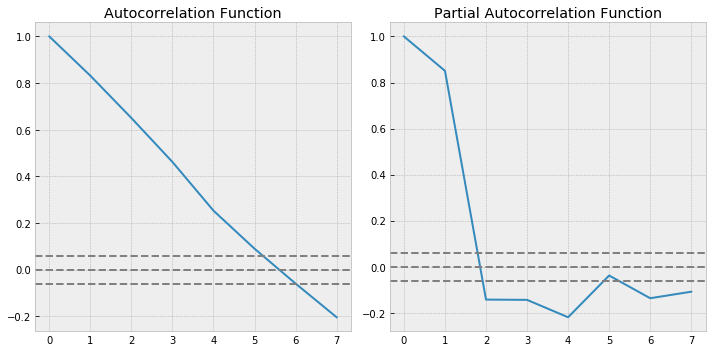

In [28]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
def viz_stationary(timeseries, n_lags):
    lag_acf = acf(timeseries, nlags=n_lags)
    lag_pacf = pacf(timeseries, nlags=n_lags, method='ols')
    f, (ax1) = plt.subplots(1, figsize = (10, 5))
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
viz_stationary(ts_log_diff,7)

In [29]:
# from pandas.plotting import autocorrelation_plot
# f, (ax1) = plt.subplots(1, figsize = (8, 6))
# autocorrelation_plot(ts_log_diff.tolist())

## Forecasting a Time Series

### What is an ARIMA model?

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

* Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
* Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

We determined the value of ‘p’ and ‘q’ using the plots above.

In the plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

* p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
* q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=5.
* D, we need to look which lagged version differencing made the series stationary.if X — X.shift(1) makes your X series stationary, D =1.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

* P = Using AutoCorrelation plot for AR
* D = For Integrated term in AR-I-MA
* Q = Using PartialAutoCorrelation plot for MA

https://www.statsmodels.org/stable/tsa.html



### AR Model

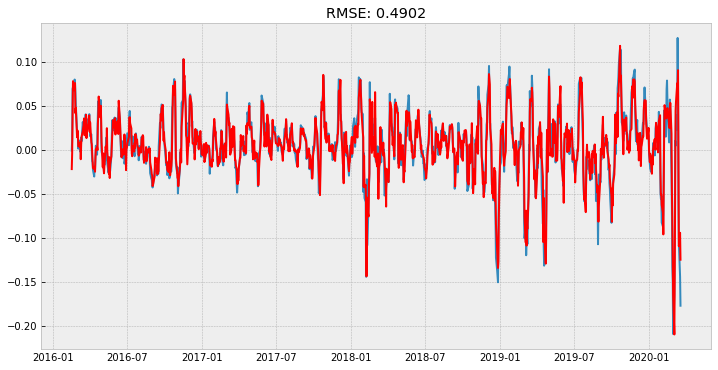

In [30]:
model = AR(ts_log_diff)  
results_AR = model.fit(disp=-1)  
f, (ax1) = plt.subplots(1, figsize = (12, 6))
plt.plot(ts_log_diff[len(ts_log_diff) - len(results_AR.fittedvalues):])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues- ts_log_diff[len(ts_log_diff) - len(results_AR.fittedvalues):])**2)))
plt.show()

### Autoregressive Moving-Average Processes (ARMA)  Model

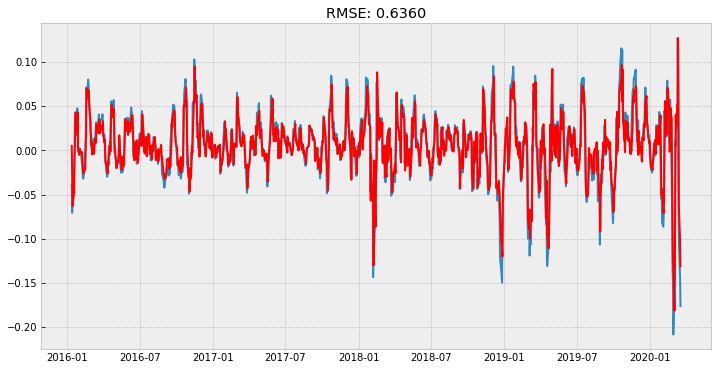

In [31]:
model = ARMA(ts_log_diff, order=(2, 1, 5))  
results_MA = model.fit(disp=-1)  
f, (ax1) = plt.subplots(1, figsize = (12, 6))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-ts_log_diff)**2)))
plt.show()

### Combined Model

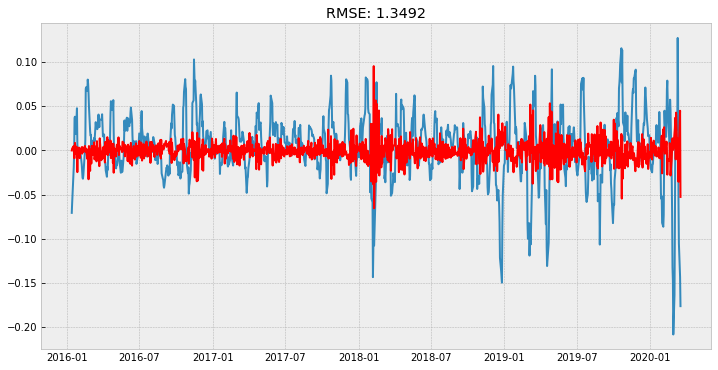

In [32]:
model = ARIMA(ts_log_diff, order=(2, 1, 5))  
results_ARIMA = model.fit(disp=-7)  
f, (ax1) = plt.subplots(1, figsize = (12, 6))
plt.plot(ts_log_diff[len(ts_log_diff) - len(results_ARIMA.fittedvalues):])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARIMA.fittedvalues- ts_log_diff[len(ts_log_diff) - len(results_ARIMA.fittedvalues):])**2)))
plt.show()

Here we can see that the ARIMA is not the best model while MA and AR models have almost the same RSS but AR is significantly better. 

## Taking it back to original scale
Since the AR model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

Once you are done with forecasting, don’t forget to trace back all transformation you made to your original series(most common mistake). Additionally, in the same reverse sequence(follow LIFO, Last applied transformation reverted first). Do create a copy of your series. It will help you out in recovering things back. For example, if you applied log() first and then differencing, first add what has been subtracted and than exp() over that.

In [33]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR_diff.head())

index
2016-02-16   -0.021377
2016-02-17   -0.002889
2016-02-18    0.037637
2016-02-19    0.078514
2016-02-22    0.069087
dtype: float64


Notice that these start from ‘2016-02-16 ’ and not the first day.

This is because we took a lag and first elements doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. 

In [34]:
normal_values = np.exp(predictions_AR_diff) + np.exp(ts_log.shift(7))

### Fill in the null values with the true values 

In [35]:
predictions_values = normal_values.combine_first(np.exp(ts_log))

In [36]:
predictions_values.head()

index
2016-01-04    116.91
2016-01-05    116.72
2016-01-06    115.78
2016-01-07    113.63
2016-01-08    112.35
dtype: float64

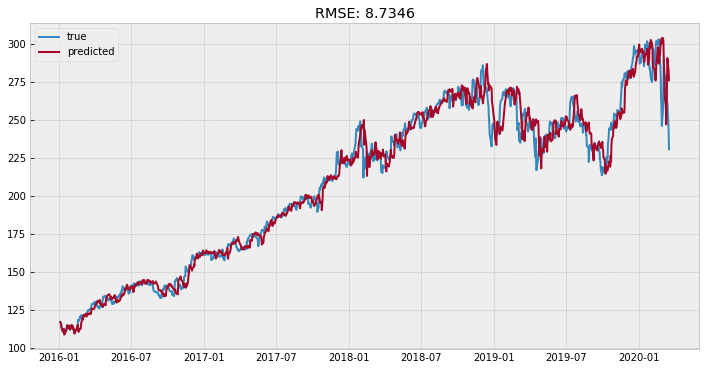

In [37]:
#predictions_AR_log = np.exp(predictions_AR_log)
f, (ax1) = plt.subplots(1, figsize = (12, 6))
plt.plot(df['open'], label = 'true')
plt.plot(predictions_values, label = 'predicted')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_values-df['open'])**2)/len(df['open'])))
plt.legend(loc="upper left")
plt.show()

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are. It is a measure of how spread out these residuals are. In other words, it tells how concentrated the data is around the line of best fit. Looking at the plot, the model is predicting the values with a lag.